In [1]:
import emcee
import numpy as np

import corner
from matplotlib import pyplot as plt
from scipy import optimize

from cr_knee_fit.inference import (
    initial_guess_model,
    make_loglikelihood,
    make_logposterior,
)
from cr_knee_fit.model import Model, ModelConfig
from cr_knee_fit.types_ import Experiment, FitData, Primary

In [2]:
PRIMARIES = [Primary.H, Primary.He, Primary.C, Primary.O]
EXPERIMENTS = [Experiment.AMS02, Experiment.DAMPE, Experiment.CALET, Experiment.CREAM]
R_BOUNDS = (7e2, 1e5)  # GV

In [3]:
fit_data = FitData.load(EXPERIMENTS, PRIMARIES, R_BOUNDS)
config = ModelConfig(
    primaries=PRIMARIES,
    shifted_experiments=[e for e in EXPERIMENTS if e is not Experiment.AMS02],
)

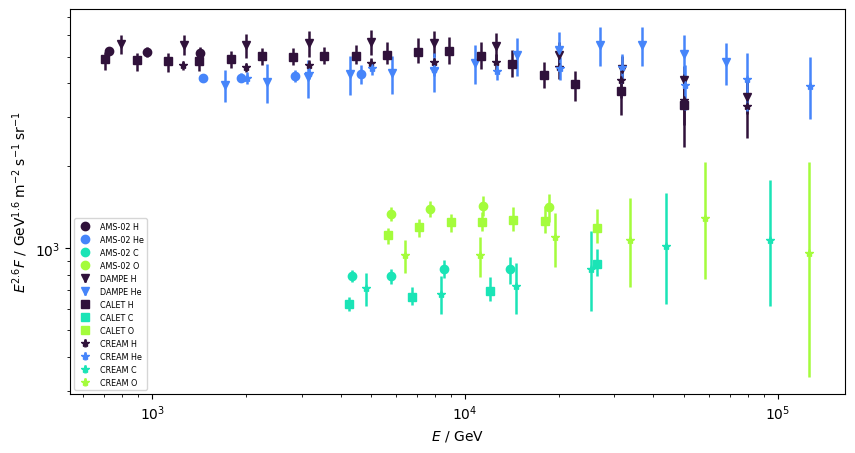

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))

for _, p_data in fit_data.spectra.items():
    for _, data in p_data.items():
        data.plot(scale=2.6, ax=ax)

ax.legend(fontsize="xx-small")
ax.set_xscale("log")
ax.set_yscale("log")

## Pre-optimization


[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (-0.05, 0.05), (-0.05, 0.05), (-0.05, 0.05)]
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 16.703665530558805
        x: [-4.079e+00  2.583e+00 ...  2.689e-02  3.271e-02]
      nit: 150
      jac: [-3.722e-02  1.314e-02 ...  5.214e-02  2.945e-02]
     nfev: 2415
     njev: 161
 hess_inv: <14x14 LbfgsInvHessProduct with dtype=float64>


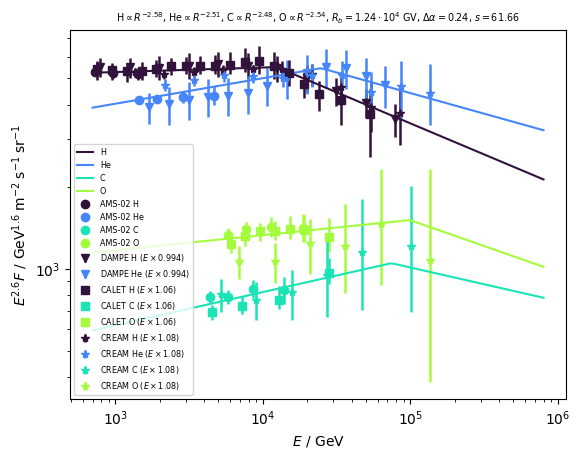

In [5]:
init_model = initial_guess_model(config)
bounds: list[tuple[float | None, float | None]] = [(None, None)] * init_model.ndim()
# FIXME: potentially unstable dependency on the model packing, assumes energy shifts are packed last
for i in range(len(init_model.energy_shifts.lg_shifts)):
    bounds[len(bounds) - i - 1] = (-0.05, 0.05)
print(bounds)

loglike = make_loglikelihood(fit_data, config)


def minimized_fn(v: np.ndarray) -> float:
    return -loglike(v)


res = optimize.minimize(
    minimized_fn,
    x0=init_model.pack(),
    # method="Nelder-Mead",
    options={
        "maxiter": 100_000,
    },
    bounds=bounds,
)
print(res)

_ = Model.unpack(res.x, layout_info=config).plot(fit_data, scale=2.6)

In [6]:
n_steps = 10_000
n_walkers = 128
n_dim = init_model.ndim()

sampler = emcee.EnsembleSampler(
    nwalkers=n_walkers,
    ndim=n_dim,
    log_prob_fn=make_logposterior(fit_data, config),
)
initial_state = np.array([initial_guess_model(config).pack() for _ in range(n_walkers)])
sampler.run_mcmc(initial_state, nsteps=n_steps, progress=True)
print(f"Acceptance fraction: {sampler.acceptance_fraction.mean()}")

tau = sampler.get_autocorr_time(quiet=True)
print(f"{tau = }")

burn_in = 5 * int(tau.max())
thin = 2 * int(tau.max())

print(f"{burn_in = } {thin = }")

theta_sample: np.ndarray = sampler.get_chain(flat=True, discard=burn_in, thin=thin)  # type: ignore
print(f"MCMC sample ready, shape: {theta_sample.shape}")

  0%|          | 0/10000 [00:00<?, ?it/s]/home/njvh/Documents/Science/cr-knee-fit/.devenv/state/venv/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [07:11<00:00, 23.18it/s]


Acceptance fraction: 0.3507859375


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [ 69.10256128 195.25007241  70.84987385 182.7950379   57.43140841
 177.96080321  43.49077388 163.04483931 213.31495782 332.91761447
 155.19693708 165.84945129 176.81287222 180.82994093]


tau = array([ 69.10256128, 195.25007241,  70.84987385, 182.7950379 ,
        57.43140841, 177.96080321,  43.49077388, 163.04483931,
       213.31495782, 332.91761447, 155.19693708, 165.84945129,
       176.81287222, 180.82994093])
burn_in = 1660 thin = 664
MCMC sample ready, shape: (1536, 14)


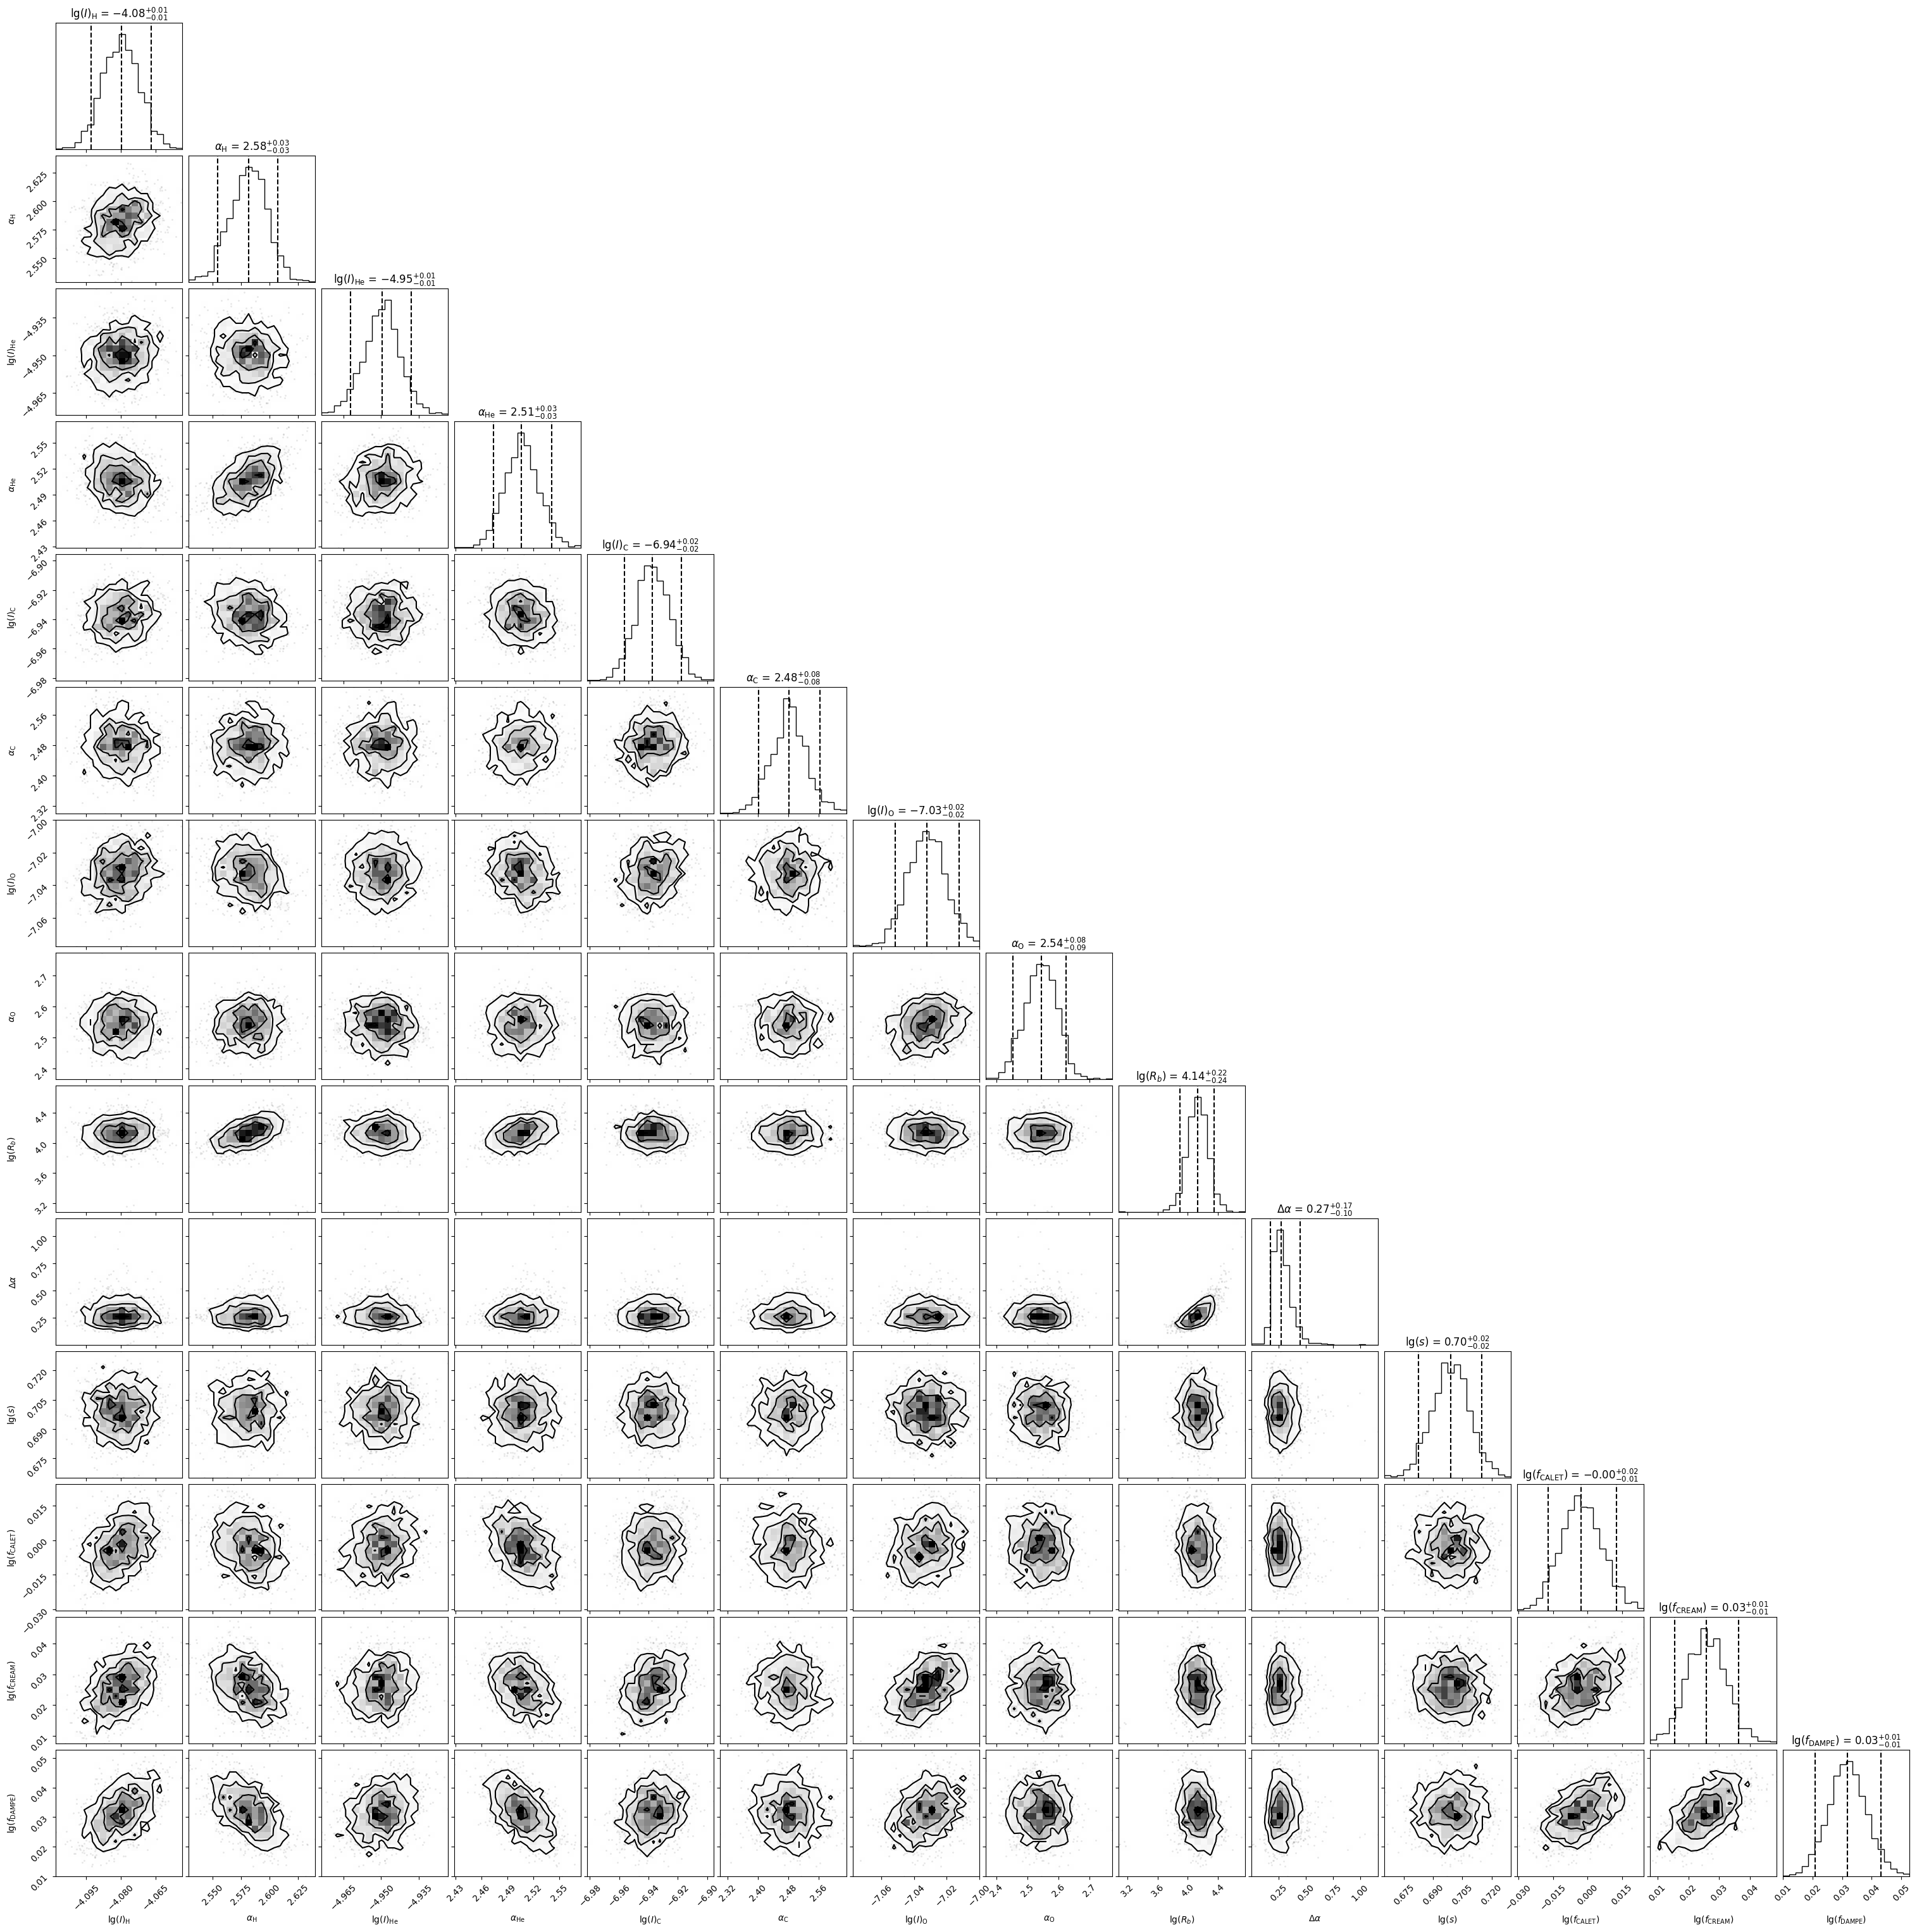

In [7]:
sample_to_plot = theta_sample
sample_labels = ["$" + label + "$" for label in init_model.labels(True)]

_ = corner.corner(
    sample_to_plot,
    labels=sample_labels,
    show_titles=True,
    # title_fmt=".2e",
    quantiles=[0.05, 0.5, 0.95],
)

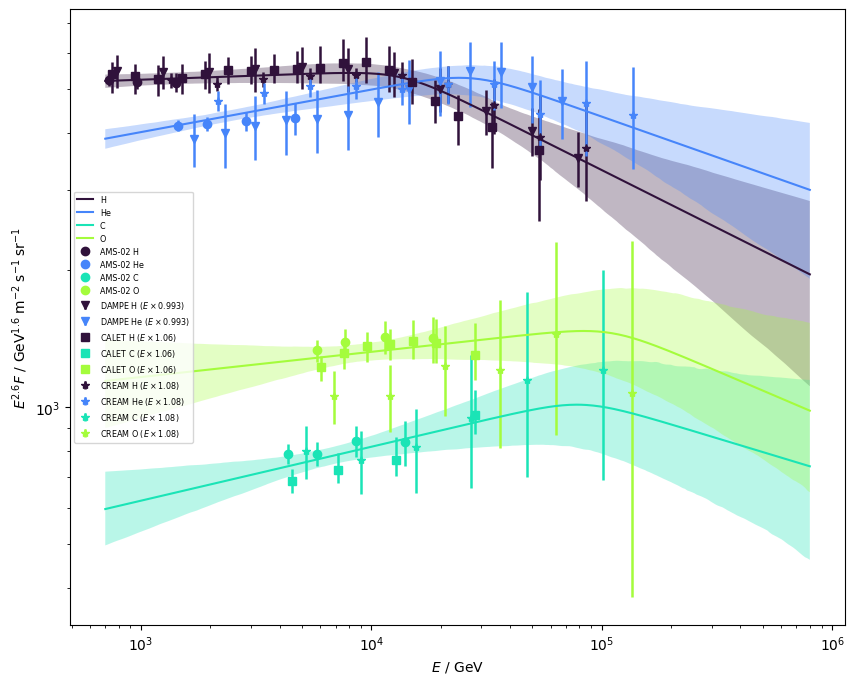

In [9]:
scale = 2.6
model_sample = [Model.unpack(theta, layout_info=config) for theta in theta_sample]
median_model = Model.unpack(np.median(theta_sample, axis=0), layout_info=config)

fig, ax = plt.subplots(figsize=(10, 8))

for exp, data_by_particle in fit_data.spectra.items():
    for _, data in data_by_particle.items():
        data.with_shifted_energy_scale(f=median_model.energy_shifts.f(exp)).plot(scale=scale, ax=ax)

primaries = list(median_model.cr.components.keys())
Emin = fit_data.R_bounds[0] * min(p.Z for p in primaries)
Emax = fit_data.R_bounds[1] * max(p.Z for p in primaries)
median_model.cr.plot(Emin, Emax, scale=scale, axes=ax)

E_grid = np.logspace(np.log10(Emin), np.log10(Emax), 300)
E_factor = E_grid**scale
for p in primaries:
    upper = []
    lower = []
    for E in E_grid:
        predictions = np.array([model.cr.compute(E, p) for model in model_sample])
        lower.append(np.quantile(predictions, q=0.05))
        upper.append(np.quantile(predictions, q=0.95))
    ax.fill_between(
        E_grid,
        E_factor * lower,
        E_factor * upper,
        color=p.color,
        alpha=0.3,
        edgecolor="none",
    )

ax.legend(fontsize="xx-small")
ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_ylim(bottom=1e3)